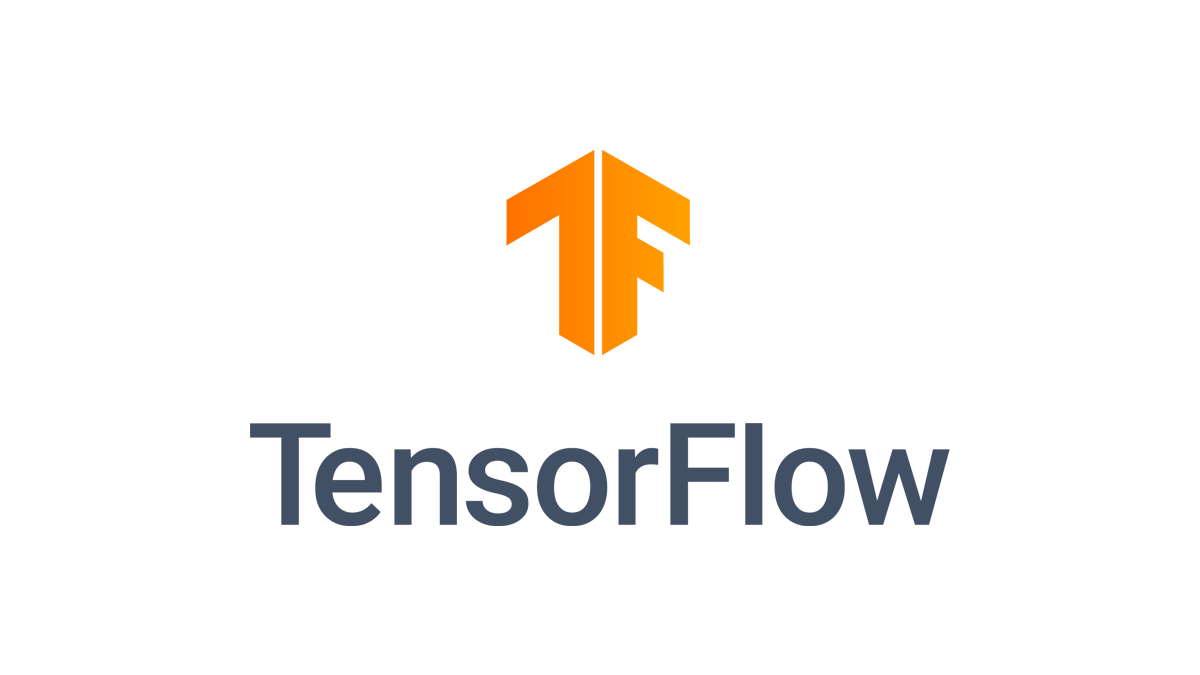

# **Brain Tumor Classification**

# Importing Modules

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/brian-tumor-dataset/metadata_rgb_only.csv
/kaggle/input/brian-tumor-dataset/metadata.csv
/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (489).jpg
/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (72).tif
/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (2411).jpg
/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1065).jpg
/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1014).jpg
/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (385).jpg
/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1822).jpg
/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (2023).jpg
/kaggle/input/brian-tumor-dataset/Brain Tumor Data Se

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
#tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping 

# Dataframe

In [3]:
# Creating dataframe by iterating through filepaths
tumor_dir=r'../input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor'
healthy_dir=r'../input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Healthy'
filepaths = []
labels= []
dict_list = [tumor_dir, healthy_dir]
for i, j in enumerate(dict_list):
    flist=os.listdir(j)
    for f in flist:
        fpath=os.path.join(j,f)
        filepaths.append(fpath)
        if i==0:
          labels.append('Brain Tumor')
        else:
          labels.append('Healthy') 
    
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
tumor_data = pd.concat([Fseries,Lseries], axis=1)
tumor_df = pd.DataFrame(tumor_data)
print(tumor_df.head())
print(tumor_df["labels"].value_counts())

                                           filepaths       labels
0  ../input/brian-tumor-dataset/Brain Tumor Data ...  Brain Tumor
1  ../input/brian-tumor-dataset/Brain Tumor Data ...  Brain Tumor
2  ../input/brian-tumor-dataset/Brain Tumor Data ...  Brain Tumor
3  ../input/brian-tumor-dataset/Brain Tumor Data ...  Brain Tumor
4  ../input/brian-tumor-dataset/Brain Tumor Data ...  Brain Tumor
Brain Tumor    2513
Healthy        2087
Name: labels, dtype: int64


In [4]:
#shape of datatset
tumor_df.shape

(4600, 2)

# Splitting Tumor Data using train_test_split

In [5]:
#splitting data
train_images, test_images = train_test_split(tumor_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(tumor_df, test_size=0.2, random_state=42)

In [6]:
#shape of splitted data
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(3680, 2)
(1380, 2)
(920, 2)
(3220, 2)


# ImageDataGenerator

In [7]:
#Generate batches of tensor image data with real-time data augmentation.
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 3680 validated image filenames belonging to 2 classes.
Found 1380 validated image filenames belonging to 2 classes.
Found 920 validated image filenames belonging to 2 classes.


In [11]:
classes=list(train.class_indices.keys())
print (classes)

['Brain Tumor', 'Healthy']


# Visualizing Images of Brain

In [12]:
def show_brain_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator 
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

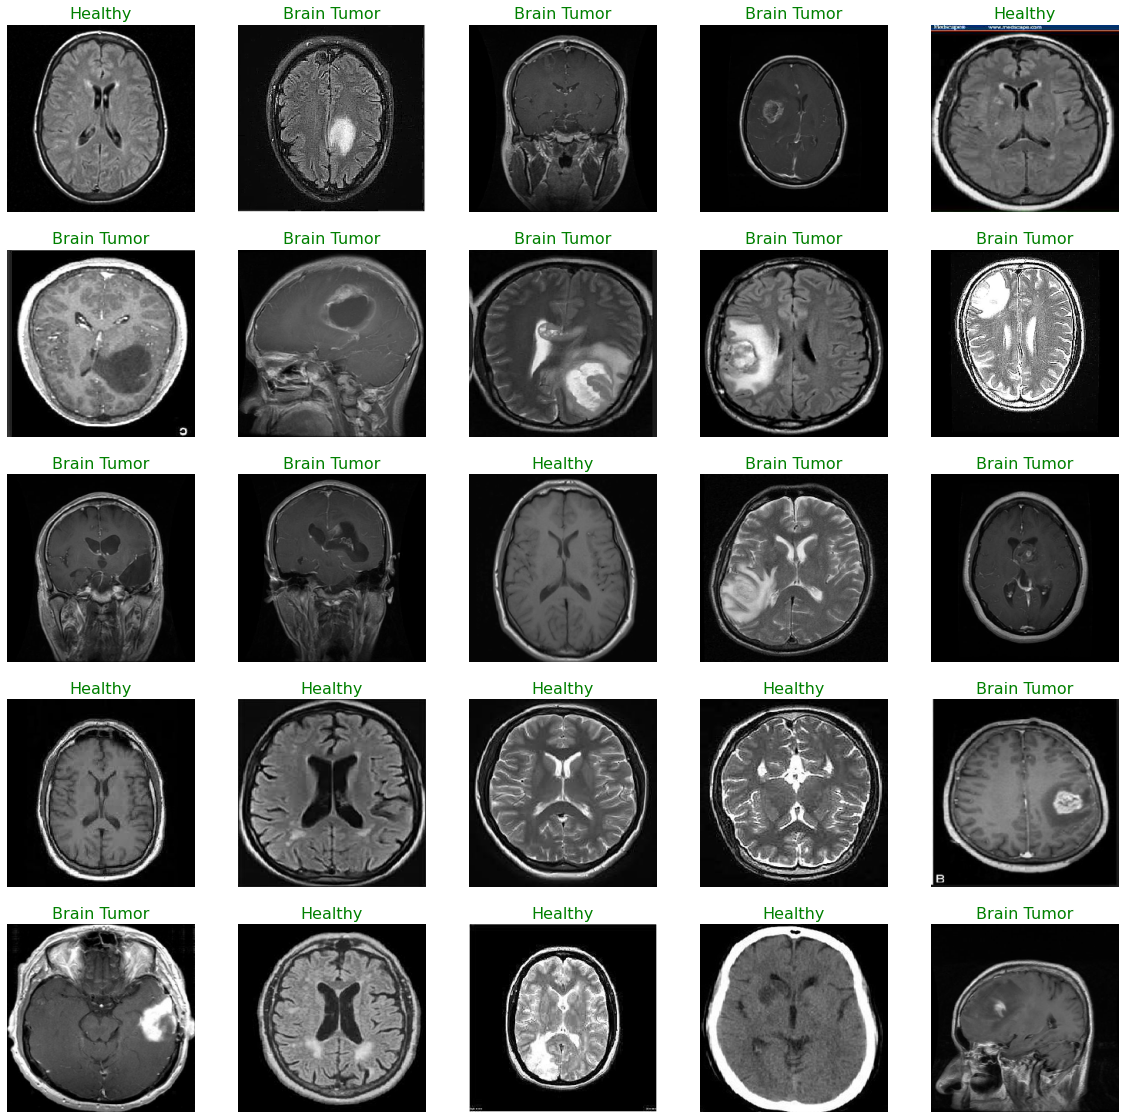

In [13]:
show_brain_images(train)

# Model Training

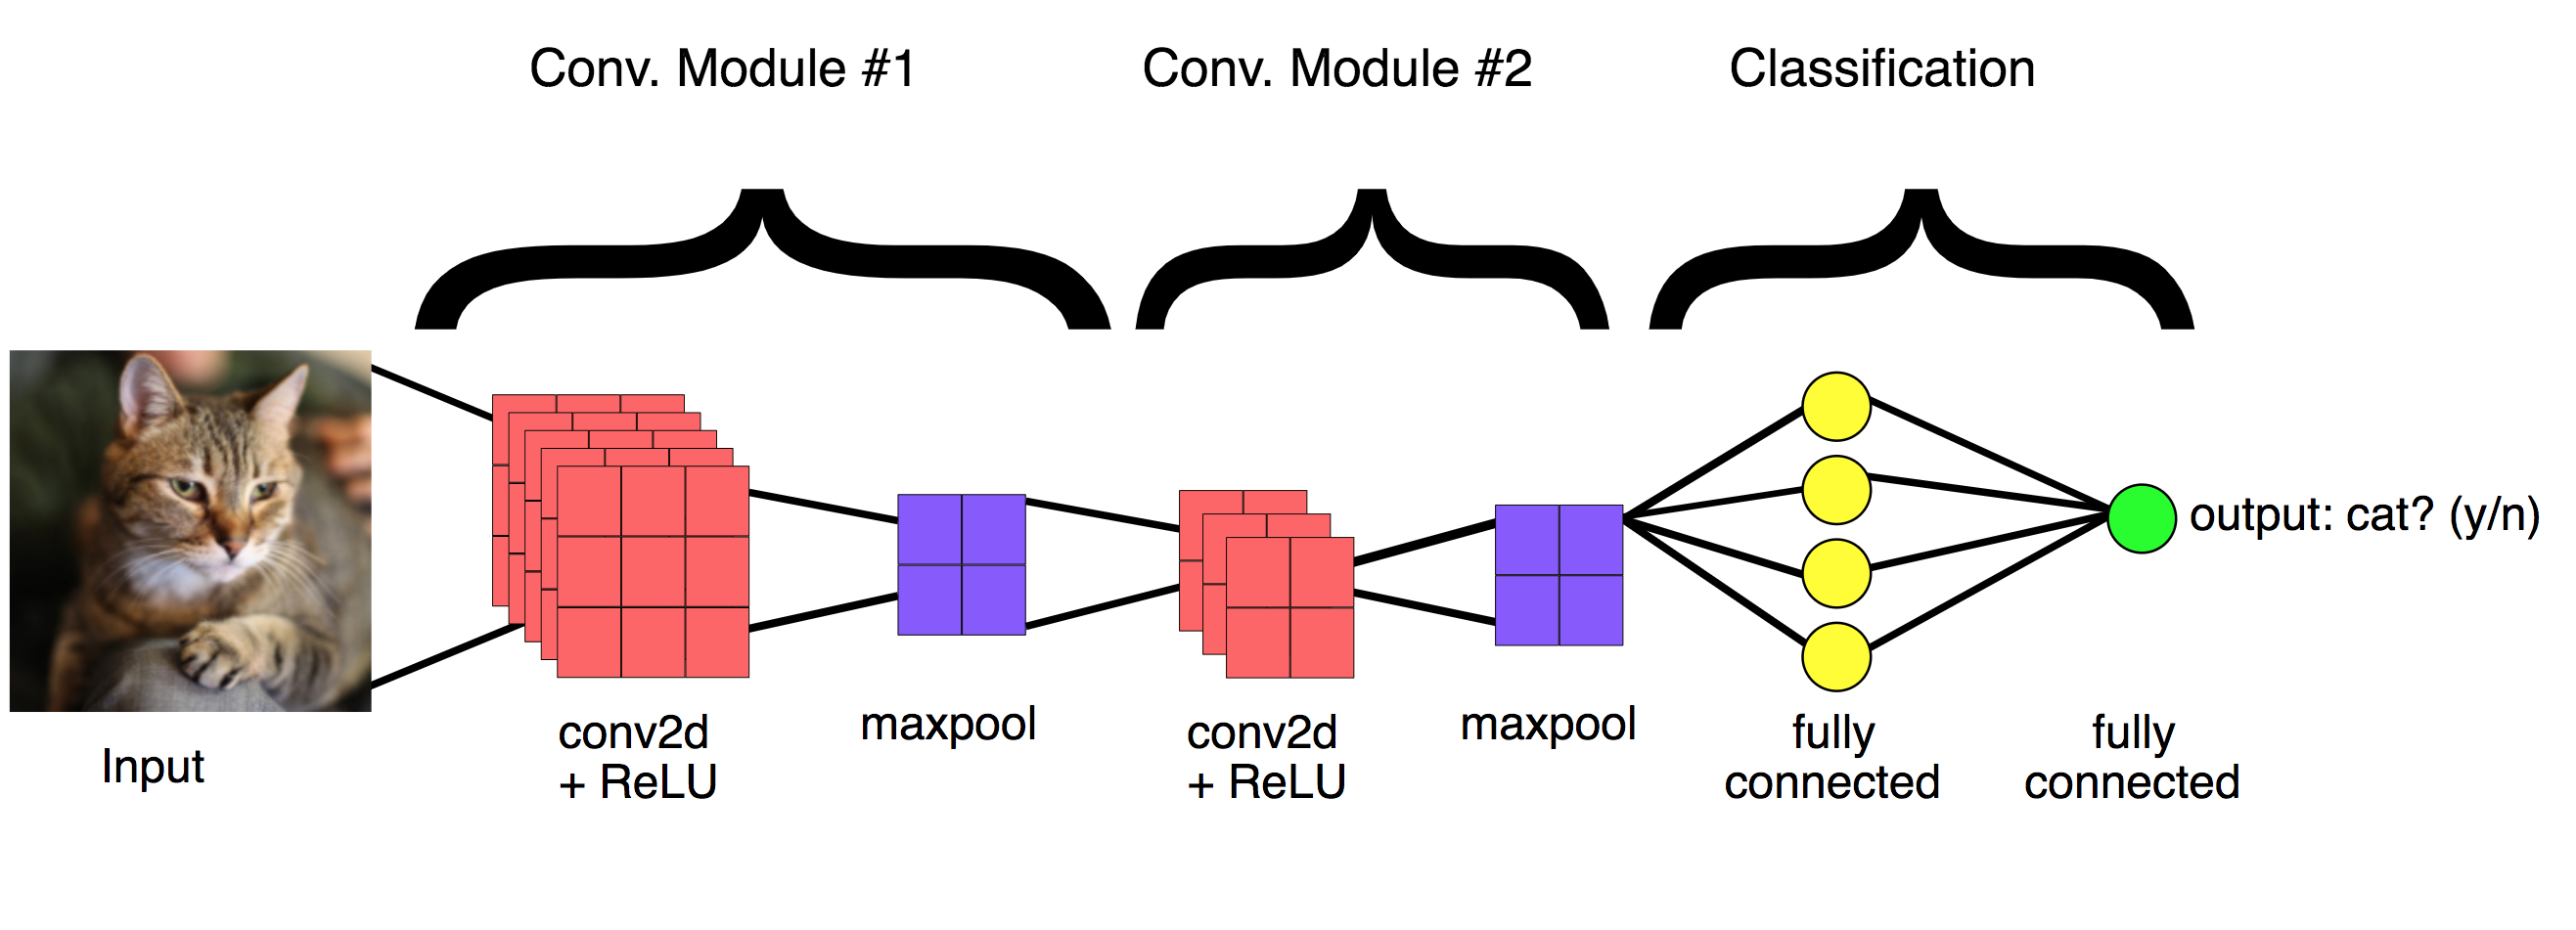

In [16]:
#Defining Sequential Model
model = Sequential()
# defining conv-pool layer
model.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1), activation="relu", padding="valid",
               input_shape=(244,244,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

#adding flatten layer
model.add(Flatten())

#adding dense layers with dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(64, activation="relu"))

#Output layer
model.add(Dense(2, activation="sigmoid")) #Sigmoid is used for binary. Use Softmax for Mutliclass.

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
#Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 242, 242, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 121, 121, 32)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 468512)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               59969664  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                

In [17]:
#fitting model
History = model.fit(train, validation_data= val, epochs=10,verbose=1)

Epoch 1/10
115/115 [==============================] - 154s 1s/step - loss: 4.5239 - accuracy: 0.6558 - val_loss: 0.2781 - val_accuracy: 0.9065
Epoch 2/10
115/115 [==============================] - 152s 1s/step - loss: 0.2605 - accuracy: 0.8956 - val_loss: 0.2104 - val_accuracy: 0.9293
Epoch 3/10
115/115 [==============================] - 153s 1s/step - loss: 0.1125 - accuracy: 0.9621 - val_loss: 0.1118 - val_accuracy: 0.9707
Epoch 4/10
115/115 [==============================] - 153s 1s/step - loss: 0.0616 - accuracy: 0.9808 - val_loss: 0.1220 - val_accuracy: 0.9630
Epoch 5/10
115/115 [==============================] - 139s 1s/step - loss: 0.0893 - accuracy: 0.9721 - val_loss: 0.1118 - val_accuracy: 0.9717
Epoch 6/10
115/115 [==============================] - 139s 1s/step - loss: 0.1073 - accuracy: 0.9671 - val_loss: 0.1672 - val_accuracy: 0.9576
Epoch 7/10
115/115 [==============================] - 139s 1s/step - loss: 0.0987 - accuracy: 0.9700 - val_loss: 0.1152 - val_accuracy: 0.9707

# Visualizing Accuracy and Loss

Text(0.5, 1.0, 'Training and Validation Accuracy')

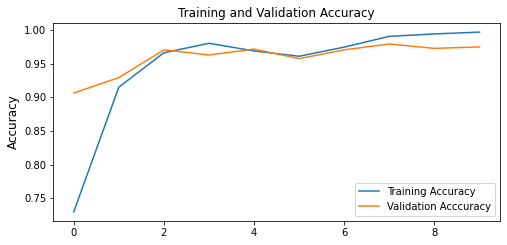

In [18]:
acc = History.history["accuracy"] # report of model
val_acc = History.history["val_accuracy"] # history of validation data

loss = History.history["loss"]        # Training loss
val_loss = History.history["val_loss"] # validation loss

plt.figure(figsize=(8,8))
plt.subplot(2,1,1) # 2 rows and 1 columns
#plotting respective accuracy
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc, label="Validation Acccuracy")

plt.legend()
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)

Text(0.5, 1.0, 'Training and Validation Losses')

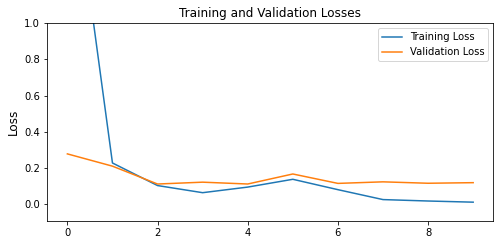

In [19]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
 
plt.plot(loss, label="Training Loss")      #Training loss
plt.plot(val_loss, label="Validation Loss") # Validation Loss

plt.legend()
plt.ylim([min(plt.ylim()),1])
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Losses", fontsize=12)

In [20]:
model.evaluate(test)

44/44 [==============================] - 15s 345ms/step - loss: 0.0797 - accuracy: 0.9833


[0.07968014478683472, 0.9833333492279053]

In [21]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

In [23]:
y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))

              precision    recall  f1-score   support

 Brain Tumor       0.98      0.99      0.99       779
     Healthy       0.99      0.98      0.98       601

    accuracy                           0.98      1380
   macro avg       0.98      0.98      0.98      1380
weighted avg       0.98      0.98      0.98      1380



<AxesSubplot:>

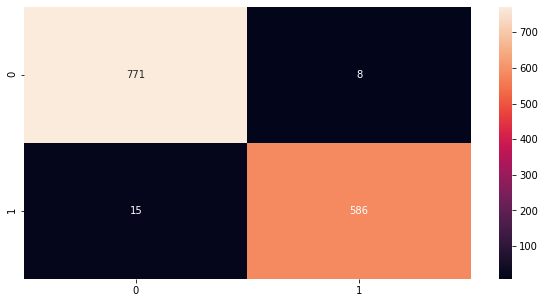

In [24]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize = (10,5))
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm, annot=True, fmt = 'g')

In [26]:
model.save('/kaggle/working/tf_brain_tumor_model.h5')